In [1]:
import pandas as pd
from sklearn.neighbors import BallTree
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
camerasF = pd.read_csv("Automated_Traffic_Enforcement_Table.csv")

camerasF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ENFORCEMENT_SPACE_CODE  719 non-null    object 
 1   LOCATION_DESCRIPTION    554 non-null    object 
 2   SITE_CODE               554 non-null    float64
 3   ACTIVE_STATUS           719 non-null    object 
 4   CAMERA_STATUS           719 non-null    object 
 5   START_DATE              554 non-null    object 
 6   END_DATE                0 non-null      float64
 7   DEVICE_MOBILITY         96 non-null     object 
 8   ENFORCEMENT_TYPE        718 non-null    object 
 9   SPEED_LIMIT             485 non-null    float64
 10  CAMERA_LATITUDE         313 non-null    float64
 11  CAMERA_LONGITUDE        313 non-null    float64
 12  CAMERA_EASTING          313 non-null    float64
 13  CAMERA_NORTHING         313 non-null    float64
 14  OBJECTID                719 non-null    in

In [3]:
# Drop 'END_DATE' & 'DEVICE_MOBILITY'
camerasF.drop(['END_DATE','DEVICE_MOBILITY'], axis=1, inplace=True)

### Only keep rows w/ no missing values
camerasF = camerasF.dropna()
camerasF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 308 entries, 1 to 717
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ENFORCEMENT_SPACE_CODE  308 non-null    object 
 1   LOCATION_DESCRIPTION    308 non-null    object 
 2   SITE_CODE               308 non-null    float64
 3   ACTIVE_STATUS           308 non-null    object 
 4   CAMERA_STATUS           308 non-null    object 
 5   START_DATE              308 non-null    object 
 6   ENFORCEMENT_TYPE        308 non-null    object 
 7   SPEED_LIMIT             308 non-null    float64
 8   CAMERA_LATITUDE         308 non-null    float64
 9   CAMERA_LONGITUDE        308 non-null    float64
 10  CAMERA_EASTING          308 non-null    float64
 11  CAMERA_NORTHING         308 non-null    float64
 12  OBJECTID                308 non-null    int64  
 13  GLOBALID                308 non-null    object 
 14  WARD                    308 non-null    float64

In [4]:
crashes = pd.read_csv("crashesClean.csv")
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303606 entries, 0 to 303605
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ADDRESS               303606 non-null  object 
 1   LATITUDE              303606 non-null  float64
 2   LONGITUDE             303606 non-null  float64
 3   WARD                  303604 non-null  object 
 4   TOTAL_VEHICLES        303606 non-null  int64  
 5   TOTAL_BICYCLES        303606 non-null  int64  
 6   TOTAL_PEDESTRIANS     303606 non-null  int64  
 7   NEARESTINTSTREETNAME  303606 non-null  object 
 8   OFFINTERSECTION       303606 non-null  float64
 9   crash_datetime        303606 non-null  object 
 10  year                  303606 non-null  int64  
 11  month                 303606 non-null  int64  
 12  weekday               303606 non-null  object 
 13  fatalities            303606 non-null  float64
 14  majorinjuries         303606 non-null  float64
 15  

In [5]:
### Step 1: ensure date columns are in 'datetime' format
crashes['crash_datetime'] = pd.to_datetime(crashes['crash_datetime'])
camerasF['START_DATE'] = pd.to_datetime(camerasF['START_DATE'])

# Verify changes
crashes.info()
camerasF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303606 entries, 0 to 303605
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   ADDRESS               303606 non-null  object             
 1   LATITUDE              303606 non-null  float64            
 2   LONGITUDE             303606 non-null  float64            
 3   WARD                  303604 non-null  object             
 4   TOTAL_VEHICLES        303606 non-null  int64              
 5   TOTAL_BICYCLES        303606 non-null  int64              
 6   TOTAL_PEDESTRIANS     303606 non-null  int64              
 7   NEARESTINTSTREETNAME  303606 non-null  object             
 8   OFFINTERSECTION       303606 non-null  float64            
 9   crash_datetime        303606 non-null  datetime64[ns, UTC]
 10  year                  303606 non-null  int64              
 11  month                 303606 non-null  int64        

In [6]:
### Step 2: Match each crash to nearest camera

# Prepare camera coordinates in radians
camera_coords = np.radians(camerasF[['CAMERA_LATITUDE', 'CAMERA_LONGITUDE']])
crash_coords = np.radians(crashes[['LATITUDE', 'LONGITUDE']])

tree = BallTree(camera_coords, metric='haversine')

distances, indices = tree.query(crash_coords, k=1)
# Convert radians to meters
distances_meters = distances * 6371000

crashes['nearest_camera_id'] = indices
crashes['dist_to_camera_m'] = distances_meters


# Verify changes
crashes.info()
crashes['nearest_camera_id'].value_counts()
crashes['dist_to_camera_m'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303606 entries, 0 to 303605
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   ADDRESS               303606 non-null  object             
 1   LATITUDE              303606 non-null  float64            
 2   LONGITUDE             303606 non-null  float64            
 3   WARD                  303604 non-null  object             
 4   TOTAL_VEHICLES        303606 non-null  int64              
 5   TOTAL_BICYCLES        303606 non-null  int64              
 6   TOTAL_PEDESTRIANS     303606 non-null  int64              
 7   NEARESTINTSTREETNAME  303606 non-null  object             
 8   OFFINTERSECTION       303606 non-null  float64            
 9   crash_datetime        303606 non-null  datetime64[ns, UTC]
 10  year                  303606 non-null  int64              
 11  month                 303606 non-null  int64        

dist_to_camera_m
172.531889    480
574.709681    397
953.904353    377
668.995241    372
99.312380     341
             ... 
585.150776      1
162.140780      1
622.553144      1
584.648598      1
649.048550      1
Name: count, Length: 127359, dtype: int64

In [7]:
crashes['severity'].value_counts()

severity
Property Damage Only    219833
Injury                   83206
Fatal                      567
Name: count, dtype: int64

In [8]:
### Step 3: Subset crashes <=100 meters from nearest camera
crashes['within_100m'] = (crashes['dist_to_camera_m'] <= 100).astype(int)

# 0 if crash is NOT <= 100 meters from camera, else 1
crashes['within_100m'].value_counts()

within_100m
0    250714
1     52892
Name: count, dtype: int64

In [9]:
### Step 4: Identify pre/post camera activation
crashes = crashes.merge(
    camerasF[['START_DATE']].reset_index().rename(columns={'index':'cam_id'}),
    left_on='nearest_camera_id',
    right_on='cam_id',
    how='left'
)

crashes['post'] = (crashes['crash_datetime'] >= crashes['START_DATE']).astype(int)
# 0 if crash is BEFORE nearest camera installation, else 1
crashes['post'].value_counts()

# Calculate DiD effect
crashes['did'] = crashes['within_100m'] * crashes['post']

# Verify Changes
crashes.describe()

,LATITUDE,LONGITUDE,TOTAL_VEHICLES,TOTAL_BICYCLES,TOTAL_PEDESTRIANS,OFFINTERSECTION,year,month,fatalities,majorinjuries,minorinjuries,speeding,impaired,nearest_camera_id,dist_to_camera_m,within_100m,cam_id,post,did
count,303606.000000,303606.000000,303606.000000,303606.000000,303606.000000,303606.000000,303606.000000,303606.000000,303606.000000,303606.000000,303606.000000,303606.000000,303606.000000,303606.000000,3.036060e+05,303606.000000,98585.000000,303606.000000,303606.000000
mean,38.903834,-77.005552,1.970593,0.022595,0.050569,33.757209,2017.994608,6.540062,0.001937,0.071942,0.296509,0.019384,0.019400,153.459059,3.903424e+02,0.174213,94.964599,0.030421,0.004921
std,0.031143,0.396949,0.573434,0.152157,0.237884,88.870747,3.945864,3.361857,0.045512,0.340638,0.654249,0.137870,0.137927,85.478810,2.812793e+04,0.379293,73.362882,0.171743,0.069976
min,38.805520,-77.118281,0.000000,-9.000000,0.000000,0.000000,2011.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.159352e-01,0.000000,1.000000,0.000000,0.000000
25%,38.887208,-77.030868,2.000000,0.000000,0.000000,3.210000,2015.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,83.000000,1.366963e+02,0.000000,36.000000,0.000000,0.000000
50%,38.904099,-77.009135,2.000000,0.000000,0.000000,21.290000,2018.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,159.000000,2.658300e+02,0.000000,83.000000,0.000000,0.000000
75%,38.921619,-76.983077,2.000000,0.000000,0.000000,47.150000,2021.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.000000,4.458027e+02,0.000000,119.000000,0.000000,0.000000
max,38.994120,77.012701,16.000000,3.000000,12.000000,6680.610000,2025.000000,12.000000,2.000000,44.000000,19.000000,1.000000,1.000000,307.000000,1.095955e+07,1.000000,229.000000,1.000000,1.000000


In [16]:
### Step 5: Aggregate Data into monthly crash counts
crashes['year_month'] = crashes['crash_datetime'].dt.to_period('M')

monthly = crashes.groupby(
    ['nearest_camera_id', 'year_month', 'within_100m', 'post', 'severity']
).size().reset_index(name='crash_count')


/var/folders/rl/6mrqzg_d1cvg3699yh85hvqm0000gp/T/ipykernel_68385/3002499086.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  crashes['year_month'] = crashes['crash_datetime'].dt.to_period('M')


In [17]:
### Step 6: Run DiD (Difference in Differences) Regression

# Ensure correct types
monthly['year_month'] = monthly['year_month'].astype(str)

# Create explicit interaction term
monthly['did_interaction'] = monthly['within_100m'] * monthly['post']

# Specify model using explicit interaction
formula = """
    crash_count ~ within_100m + post + did_interaction
    + C(nearest_camera_id)
    + C(year_month)
"""

model = smf.ols(
    formula=formula,
    data=monthly
).fit(cov_type='cluster', cov_kwds={'groups': monthly['nearest_camera_id']})

# Extract DiD estimate
did_effect = model.params["did_interaction"]
did_pvalue = model.pvalues["did_interaction"]

print("DiD effect (beta3):", did_effect)
print("p-value:", did_pvalue)


DiD effect (beta3): 0.5806702948234406
p-value: 0.01251594903347118


In [18]:
# View Results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            crash_count   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     134.2
Date:                Tue, 25 Nov 2025   Prob (F-statistic):          1.50e-222
Time:                        17:42:14   Log-Likelihood:            -2.6016e+05
No. Observations:              105694   AIC:                         5.213e+05
Df Residuals:                  105210   BIC:                         5.259e+05
Df Model:                         483                                         
Covariance Type:              cluster                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

/Users/mproctor/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/mproctor/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/mproctor/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/mproctor/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 483, but rank is 180
  warnings.warn('covariance of constraints does not have full '


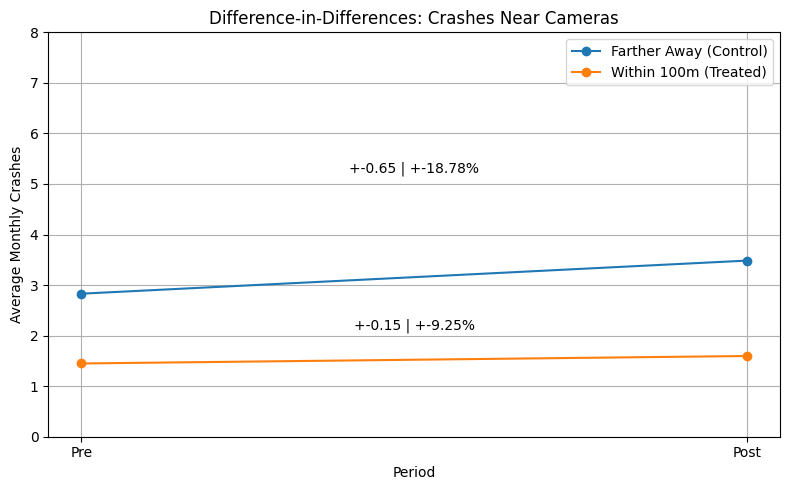

In [19]:
### Plot 1: Average # of Monthly Crashes 
# Ensure 'period' is defined
monthly['period'] = monthly['post'].map({0: 'Pre', 1: 'Post'})

# Compute mean crash counts for treated vs control
agg = monthly.groupby(['within_100m', 'period'])['crash_count'].mean().reset_index()
agg['group'] = agg['within_100m'].map({1: 'Within 100m (Treated)', 0: 'Farther Away (Control)'})

plt.figure(figsize=(8,5))

for group, df_group in agg.groupby('group'):
    plt.plot(df_group['period'], df_group['crash_count'], marker='o', label=group)
    
    pre = df_group.loc[df_group['period'] == 'Pre', 'crash_count'].values[0]
    post = df_group.loc[df_group['period'] == 'Post', 'crash_count'].values[0]
    abs_increase = post - pre
    pct_increase = abs_increase / pre * 100 if pre != 0 else 0

    # Set fixed y-positions for annotations
    y_pos = 2.2 if 'Treated' in group else 5.3
    x_pos = 0.5  # halfway between Pre (0) and Post (1)
    
    plt.text(x_pos, y_pos, f"+{abs_increase:.2f} | +{pct_increase:.2f}%", 
             ha='center', va='center', fontsize=10)

plt.title('Difference-in-Differences: Crashes Near Cameras')
plt.ylabel('Average Monthly Crashes')
plt.xlabel('Period')
plt.ylim(0, 8)  # fixed y-axis
plt.xticks([0, 1], ['Pre', 'Post'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/rl/6mrqzg_d1cvg3699yh85hvqm0000gp/T/ipykernel_68385/4246759633.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  camera_counts = camerasF.groupby(camerasF['START_DATE'].dt.to_period('M')).size().cumsum()


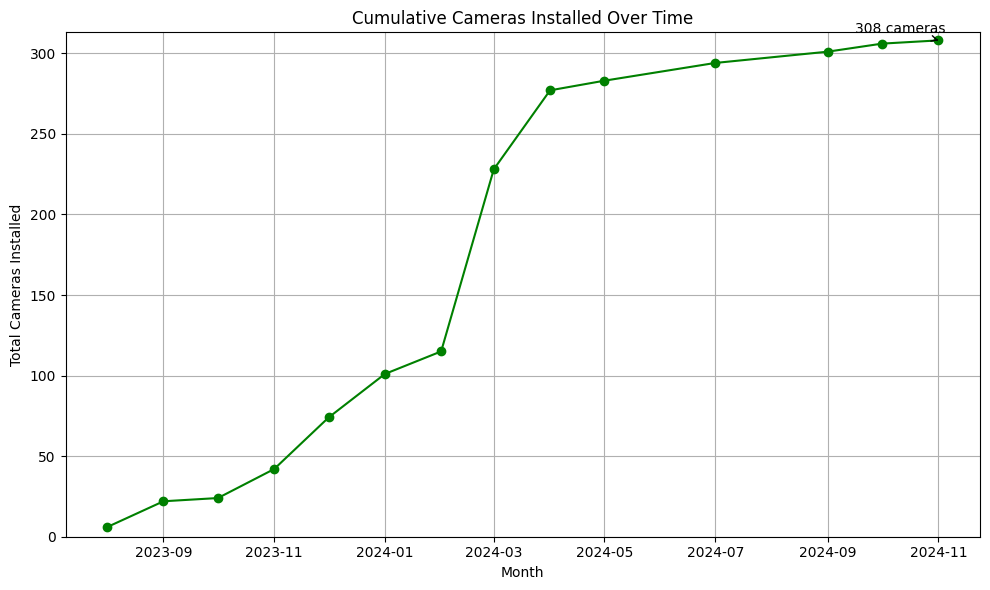

In [20]:
### Plot 2: Cumulative Number of Cameras Installed Over Time
# Make sure START_DATE is a datetime
camerasF['START_DATE'] = pd.to_datetime(camerasF['START_DATE'])

# Count number of cameras installed by month
camera_counts = camerasF.groupby(camerasF['START_DATE'].dt.to_period('M')).size().cumsum()

# Convert period index back to datetime for plotting
camera_counts.index = camera_counts.index.to_timestamp()

# Plot cumulative installations
plt.figure(figsize=(10,6))
plt.plot(camera_counts.index, camera_counts.values, marker='o', color='green')
plt.title("Cumulative Cameras Installed Over Time")
plt.xlabel("Month")
plt.ylabel("Total Cameras Installed")
plt.ylim(0, camera_counts.max() + 5)
plt.grid(True)

# Annotate the last point with total installed
plt.annotate(
    f"{camera_counts.values[-1]} cameras",
    xy=(camera_counts.index[-1], camera_counts.values[-1]),
    xytext=(-60, 5),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', color='black')
)

plt.tight_layout()
plt.show()

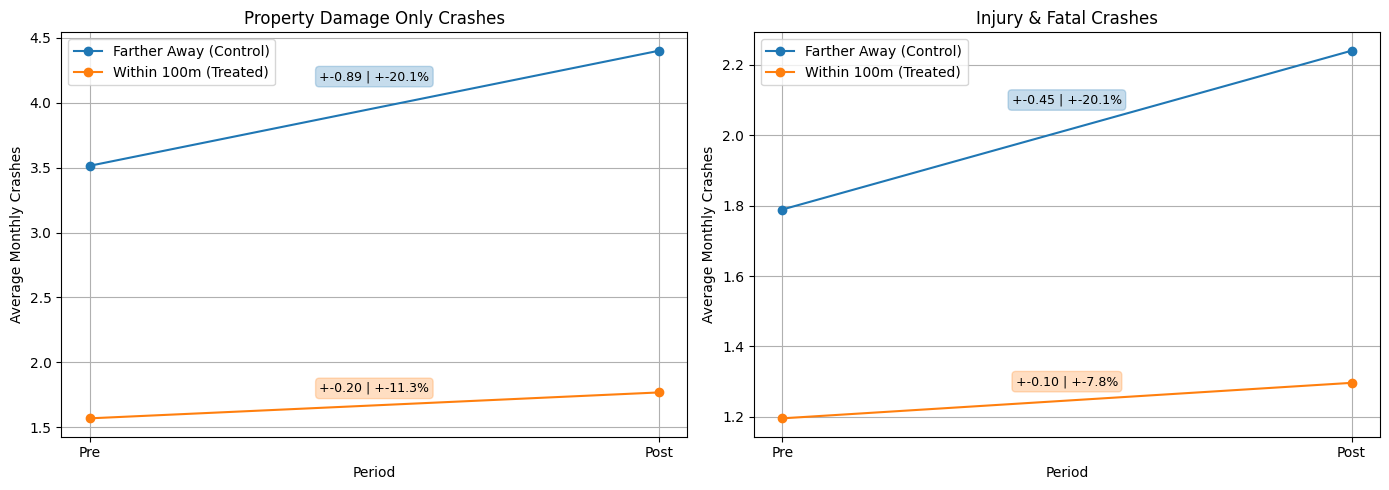

In [23]:
### Plot 3: Side-by-Side comparison of changes in average monthly PDO crashes vs Severe

import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Fixed desired y-positions for annotations
ANNOT_Y = {
    "PDO": {
        "Within 100m (Treated)": 1.8,
        "Farther Away (Control)": 4.2
    },
    "InjuryFatal": {
        "Within 100m (Treated)": 1.3,
        "Farther Away (Control)": 2.1
    }
}

# Add x-position for annotation (middle between Pre/Post)
ANNOT_X = 0.5


def make_agg(df):
    agg = (
        df.groupby(['within_100m', 'period'])['crash_count']
        .mean()
        .reset_index()
    )
    agg['group'] = agg['within_100m'].map({
        1: 'Within 100m (Treated)',
        0: 'Farther Away (Control)'
    })
    return agg


def plot_did(ax, agg, crash_type_key, title, y_label):

    for group, df_group in agg.groupby('group'):
        # Plot line
        ax.plot(df_group['period'], df_group['crash_count'], marker='o', label=group)

        # Compute changes
        pre = df_group.loc[df_group['period'] == 'Pre', 'crash_count'].values[0]
        post = df_group.loc[df_group['period'] == 'Post', 'crash_count'].values[0]
        abs_increase = post - pre
        pct_increase = abs_increase / pre * 100 if pre != 0 else 0

        # Pick annotation y-position based on crash severity + treated/control
        y_pos = ANNOT_Y[crash_type_key][group]
        x_pos = ANNOT_X

        # Pick the same color as the line
        line_color = ax.lines[-1].get_color()

        # Draw text with bounding box
        ax.text(
            x_pos,
            y_pos,
            f"+{abs_increase:.2f} | +{pct_increase:.1f}%",
            ha='center',
            va='center',
            fontsize=9,
            color='black',
            bbox=dict(
                facecolor=line_color,
                alpha=0.25,
                boxstyle="round,pad=0.3",
                edgecolor=line_color
            )
        )

    # Standard formatting
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel('Period')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Pre', 'Post'])
    ax.grid(True)
    ax.legend()


# ---------------------
# ---- BUILD FIGURE ---
# ---------------------

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot PDO
plot_did(
    axes[0],
    agg_pdo,
    crash_type_key="PDO",
    title="Property Damage Only Crashes",
    y_label="Average Monthly Crashes"
)

# Plot Injury/Fatal
plot_did(
    axes[1],
    agg_injfatal,
    crash_type_key="InjuryFatal",
    title="Injury & Fatal Crashes",
    y_label="Average Monthly Crashes"
)

plt.tight_layout()
plt.show()
